Found 188 real images.
Found 188 sketches.


Loading and Augmenting Sketch Images: 100%|██████████| 188/188 [00:00<00:00, 358.51it/s]


Total number of sketch images: 1504
Total number of real images: 1504
Arrays saved successfully!


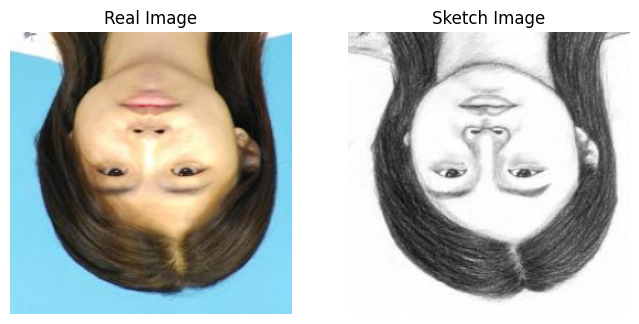

In [1]:
# === IMPORTS ===
import os
import cv2
import numpy as np
import matplotlib.pyplot as plt
from tqdm import tqdm
import re

import tensorflow as tf
from tensorflow.keras.preprocessing.image import img_to_array

# === CONFIGURATION ===
SIZE = 256
image_path = "Dataset/photos"
sketch_path = "Dataset/sketches"

# === HELPER FUNCTIONS ===

def sorted_alphanumeric(data):
    """Sort filenames properly."""
    convert = lambda text: int(text) if text.isdigit() else text.lower()
    alphanum_key = lambda key: [convert(c) for c in re.split('([0-9]+)', key)]
    return sorted(data, key=alphanum_key)

def load_and_preprocess_image(filepath, size=256):
    """Load, resize image (no normalization yet)."""
    image = cv2.imread(filepath)
    if image is None:
        print(f"Warning: Unable to load image {filepath}")
        return None
    image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
    image = cv2.resize(image, (size, size))
    return image  # keep as uint8

def augment_image(image):
    """Apply augmentations, then normalize all."""
    aug_list = [
        image,
        cv2.flip(image, 1),  # Horizontal flip
        cv2.flip(image, 0),  # Vertical flip
        cv2.flip(cv2.flip(image, 0), 1),  # Horizontal + Vertical flip
        cv2.rotate(image, cv2.ROTATE_90_CLOCKWISE),
        cv2.flip(cv2.rotate(image, cv2.ROTATE_90_CLOCKWISE), 1),
        cv2.rotate(image, cv2.ROTATE_90_COUNTERCLOCKWISE),
        cv2.flip(cv2.rotate(image, cv2.ROTATE_90_COUNTERCLOCKWISE), 1)
    ]
    # Normalize here only once
    return [img_to_array(img.astype('float32') / 255.0) for img in aug_list]

# === DATA LOADING ===

img_array = []
sketch_array = []

image_files = sorted_alphanumeric(os.listdir(image_path))
sketch_files = sorted_alphanumeric(os.listdir(sketch_path))

print(f"Found {len(image_files)} real images.")
print(f"Found {len(sketch_files)} sketches.")

# Load and augment real images
for filename in tqdm(image_files, desc="Loading and Augmenting Real Images"):
    img_fp = os.path.join(image_path, filename)
    
    image = load_and_preprocess_image(img_fp, size=SIZE)
    if image is None:
        continue  # Skip if image failed to load
    
    augmented_images = augment_image(image)
    
    img_array.extend(augmented_images)

# Load and augment sketch images
for filename in tqdm(sketch_files, desc="Loading and Augmenting Sketch Images"):
    sketch_fp = os.path.join(sketch_path, filename)
    
    sketch = load_and_preprocess_image(sketch_fp, size=SIZE)
    if sketch is None:
        continue
    
    sketch = sketch.astype('float32') / 255.0  # normalize sketch directly
    sketch_array.append(img_to_array(sketch))
    
    # Sketch augmentations
    sketch_array.append(img_to_array(cv2.flip(sketch, 1)))   # Horizontal flip
    sketch_array.append(img_to_array(cv2.flip(sketch, 0)))   # Vertical flip
    sketch_array.append(img_to_array(cv2.flip(sketch, -1)))  # H+V flip
    sketch_90_cw = cv2.rotate(sketch, cv2.ROTATE_90_CLOCKWISE)
    sketch_array.append(img_to_array(sketch_90_cw))
    sketch_90_cw_flip = cv2.flip(sketch_90_cw, 1)
    sketch_array.append(img_to_array(sketch_90_cw_flip))
    sketch_90_ccw = cv2.rotate(sketch, cv2.ROTATE_90_COUNTERCLOCKWISE)
    sketch_array.append(img_to_array(sketch_90_ccw))
    sketch_90_ccw_flip = cv2.flip(sketch_90_ccw, 1)
    sketch_array.append(img_to_array(sketch_90_ccw_flip))

# === FINAL CHECK ===

print(f"Total number of sketch images: {len(sketch_array)}")
print(f"Total number of real images: {len(img_array)}")

# Make sure counts match
assert len(img_array) == len(sketch_array), "Mismatch between real images and sketches!"

# === SAVE ARRAYS ===

np.save('Dataset/real_images/real_images.npy', np.array(img_array))
np.save('Dataset/sketch_images/sketch_images.npy', np.array(sketch_array))
print("Arrays saved successfully!")

# === PLOT SAMPLE ===

def plot_images(real_img, sketch_img):
    plt.figure(figsize=(8, 4))

    plt.subplot(1, 2, 1)
    plt.imshow(real_img)
    plt.title('Real Image')
    plt.axis('off')

    plt.subplot(1, 2, 2)
    plt.imshow(sketch_img)
    plt.title('Sketch Image')
    plt.axis('off')

    plt.show()

# Example: plot random sample
idx = np.random.randint(0, len(img_array))
plot_images(img_array[idx], sketch_array[idx])

In [2]:
import numpy as np
import tensorflow as tf

# Split into training and testing
train_sketch_image = sketch_array[:1400]
train_image = img_array[:1400]
test_sketch_image = sketch_array[1400:]
test_image = img_array[1400:]

# Convert to numpy arrays and reshape
train_sketch_image = np.reshape(train_sketch_image, (len(train_sketch_image), SIZE, SIZE, 3))
train_image = np.reshape(train_image, (len(train_image), SIZE, SIZE, 3))
test_sketch_image = np.reshape(test_sketch_image, (len(test_sketch_image), SIZE, SIZE, 3))
test_image = np.reshape(test_image, (len(test_image), SIZE, SIZE, 3))

print('Train Image Shape:', train_image.shape)
print('Train Sketch Shape:', train_sketch_image.shape)
print('Test Image Shape:', test_image.shape)
print('Test Sketch Shape:', test_sketch_image.shape)

# -------------------------------
# Building Blocks
# -------------------------------

def downsample(filters, size, apply_batchnorm=True):
    initializer = tf.random_normal_initializer(0., 0.02)
    result = tf.keras.Sequential([
        tf.keras.layers.Conv2D(filters, size, strides=2, padding='same',
                               kernel_initializer=initializer, use_bias=False)
    ])
    if apply_batchnorm:
        result.add(tf.keras.layers.BatchNormalization())
    result.add(tf.keras.layers.LeakyReLU())
    return result

def upsample(filters, size, apply_dropout=False):
    initializer = tf.random_normal_initializer(0., 0.02)
    result = tf.keras.Sequential([
        tf.keras.layers.Conv2DTranspose(filters, size, strides=2,
                                        padding='same',
                                        kernel_initializer=initializer,
                                        use_bias=False)
    ])
    if apply_dropout:
        result.add(tf.keras.layers.Dropout(0.3))
    result.add(tf.keras.layers.ReLU())
    return result

# -------------------------------
# U-Net Model (with skip connections)
# -------------------------------

def build_unet():
    inputs = tf.keras.layers.Input(shape=[SIZE, SIZE, 3])

    # Encoder
    down1 = downsample(64, 4, apply_batchnorm=False)(inputs)   # (128x128)
    down2 = downsample(128, 4)(down1)                          # (64x64)
    down3 = downsample(256, 4)(down2)                          # (32x32)
    down4 = downsample(512, 4)(down3)                          # (16x16)
    down5 = downsample(512, 4)(down4)                          # (8x8)

    # Bottleneck
    bottleneck = downsample(512, 4)(down5)                     # (4x4)

    # Decoder with skip connections
    up1 = upsample(512, 4, apply_dropout=True)(bottleneck)
    up1 = tf.keras.layers.Concatenate()([up1, down5])          # (8x8)

    up2 = upsample(512, 4, apply_dropout=True)(up1)
    up2 = tf.keras.layers.Concatenate()([up2, down4])          # (16x16)

    up3 = upsample(256, 4)(up2)
    up3 = tf.keras.layers.Concatenate()([up3, down3])          # (32x32)

    up4 = upsample(128, 4)(up3)
    up4 = tf.keras.layers.Concatenate()([up4, down2])          # (64x64)

    up5 = upsample(64, 4)(up4)
    up5 = tf.keras.layers.Concatenate()([up5, down1])          # (128x128)

    # Final layer
    last = tf.keras.layers.Conv2DTranspose(3, 4, strides=2,
                                           padding='same', activation='sigmoid')(up5) # (256x256x3)

    return tf.keras.Model(inputs=inputs, outputs=last)

# -------------------------------
# Compile Model
# -------------------------------

model = build_unet()
optimizer = tf.keras.optimizers.Adam(learning_rate=2e-4, beta_1=0.5)

model.compile(optimizer=optimizer, loss='mae')  # We'll improve loss later
model.summary()

Train Image Shape: (1400, 256, 256, 3)
Train Sketch Shape: (1400, 256, 256, 3)
Test Image Shape: (104, 256, 256, 3)
Test Sketch Shape: (104, 256, 256, 3)


Model: "functional_11"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_layer         │ (None, 256, 256,  │          0 │ -                 │
│ (InputLayer)        │ 3)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ sequential          │ (None, 128, 128,  │      3,072 │ input_layer[0][0] │
│ (Sequential)        │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ sequential_1        │ (None, 64, 64,    │    131,584 │ sequential[0][0]  │
│ (Sequential)        │ 128)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ sequential_2        │ (None, 32, 32,    │    525,312 │ sequential_1[0][… │
│ (Sequential)        │ 256)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ sequential_3        │ (None, 16, 16,    │  2,099,200 │ sequential_2[0][… │
│ (Sequential)        │ 512)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ sequential_4        │ (None, 8, 8, 512) │  4,196,352 │ sequential_3[0][… │
│ (Sequential)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ sequential_5        │ (None, 4, 4, 512) │  4,196,352 │ sequential_4[0][… │
│ (Sequential)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ sequential_6        │ (None, 8, 8, 512) │  4,194,304 │ sequential_5[0][… │
│ (Sequential)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ concatenate         │ (None, 8, 8,      │          0 │ sequential_6[0][… │
│ (Concatenate)       │ 1024)             │            │ sequential_4[0][… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ sequential_7        │ (None, 16, 16,    │  8,388,608 │ concatenate[0][0] │
│ (Sequential)        │ 512)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ concatenate_1       │ (None, 16, 16,    │          0 │ sequential_7[0][… │
│ (Concatenate)       │ 1024)             │            │ sequential_3[0][… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ sequential_8        │ (None, 32, 32,    │  4,194,304 │ concatenate_1[0]… │
│ (Sequential)        │ 256)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ concatenate_2       │ (None, 32, 32,    │          0 │ sequential_8[0][… │
│ (Concatenate)       │ 512)              │            │ sequential_2[0][… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ sequential_9        │ (None, 64, 64,    │  1,048,576 │ concatenate_2[0]… │
│ (Sequential)        │ 128)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ concatenate_3       │ (None, 64, 64,    │          0 │ sequential_9[0][… │
│ (Concatenate)       │ 256)              │            │ sequential_1[0][… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ sequential_10       │ (None, 128, 128,  │    262,144 │ concatenate_3[0]… │
│ (Sequential)        │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ concatenate_4       │ (None, 128, 128,  │          0 │ sequential_10[0]

 Total params: 29,245,955 (111.56 MB)

 Trainable params: 29,242,115 (111.55 MB)

 Non-trainable params: 3,840 (15.00 KB)

Train Sketch Shape: (1400, 256, 256, 3)
Train Image Shape: (1400, 256, 256, 3)
Test Sketch Shape: (104, 256, 256, 3)
Test Image Shape: (104, 256, 256, 3)

Epoch 1: LearningRateScheduler setting learning rate to 0.00019999999494757503.
Epoch 1/20
44/44 ━━━━━━━━━━━━━━━━━━━━ 367s 8s/step - loss: 0.2450 - val_loss: 0.2588 - learning_rate: 2.0000e-04

Epoch 2: LearningRateScheduler setting learning rate to 0.00019999950018245727.
Epoch 2/20
44/44 ━━━━━━━━━━━━━━━━━━━━ 387s 9s/step - loss: 0.1667 - val_loss: 0.2566 - learning_rate: 2.0000e-04

Epoch 3: LearningRateScheduler setting learning rate to 0.00019999801588710397.
Epoch 3/20
44/44 ━━━━━━━━━━━━━━━━━━━━ 399s 9s/step - loss: 0.1286 - val_loss: 0.2620 - learning_rate: 2.0000e-04

Epoch 4: LearningRateScheduler setting learning rate to 0.00019999555661343038.
Epoch 4/20
44/44 ━━━━━━━━━━━━━━━━━━━━ 308s 7s/step - loss: 0.1238 - val_loss: 0.2654 - learning_rate: 2.0000e-04

Epoch 5: LearningRateScheduler setting learning rate to 0.00019999210

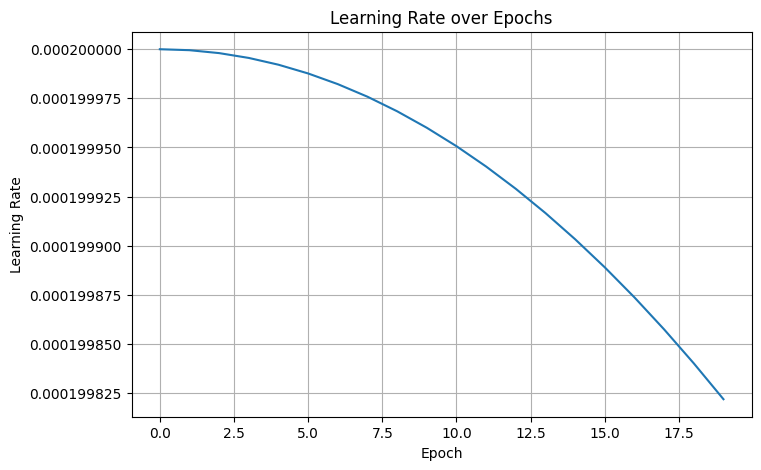

In [4]:
import tensorflow as tf
import matplotlib.pyplot as plt

# -------------------------------
# Loss Function and Optimizer
# -------------------------------

# L1 Loss
loss_object = tf.keras.losses.MeanAbsoluteError()

# SSIM Loss
def ssim_loss(y_true, y_pred):
    return 1 - tf.reduce_mean(tf.image.ssim(y_true, y_pred, max_val=1.0))

# Mixed Loss (L1 + SSIM)
def mixed_loss(y_true, y_pred):
    return 0.84 * loss_object(y_true, y_pred) + 0.16 * ssim_loss(y_true, y_pred)

# Optimizer (Adam with beta_1=0.5, good for images)
initial_learning_rate = 2e-4
generator_optimizer = tf.keras.optimizers.Adam(initial_learning_rate, beta_1=0.5)

# Cosine Decay Learning Rate Scheduler
lr_schedule = tf.keras.optimizers.schedules.CosineDecay(
    initial_learning_rate=initial_learning_rate,
    decay_steps=1000
)

# -------------------------------
# Compile Model
# -------------------------------

# Build your model (assuming you have a build_unet() function)
model = build_unet()
model.compile(optimizer=generator_optimizer, loss=mixed_loss)

# -------------------------------
# Callbacks
# -------------------------------

# Early stopping
early_stop = tf.keras.callbacks.EarlyStopping(
    monitor='val_loss', patience=10, restore_best_weights=True)

# Learning rate scheduler callback
lr_callback = tf.keras.callbacks.LearningRateScheduler(
    lambda epoch: lr_schedule(epoch).numpy(), verbose=1)

# Model checkpoint
checkpoint_cb = tf.keras.callbacks.ModelCheckpoint(
    "best_model.keras",
    save_best_only=True,
    monitor="val_loss",
    mode="min"
)

# Custom Callback to Track Learning Rate
class LearningRatePlotCallback(tf.keras.callbacks.Callback):
    def __init__(self):
        super().__init__()
        self.lrs = []

    def on_epoch_end(self, epoch, logs=None):
        lr = self.model.optimizer.learning_rate  # <-- FIXED
        if isinstance(lr, tf.keras.optimizers.schedules.LearningRateSchedule):
            lr = lr(epoch)
        self.lrs.append(tf.keras.backend.get_value(lr))

lr_plot_callback = LearningRatePlotCallback()

# -------------------------------
# Data Check
# -------------------------------

# Make sure x and y have same number of samples!
print(f"Train Sketch Shape: {train_sketch_image.shape}")
print(f"Train Image Shape: {train_image.shape}")
print(f"Test Sketch Shape: {test_sketch_image.shape}")
print(f"Test Image Shape: {test_image.shape}")

# -------------------------------
# Train the Model
# -------------------------------

history = model.fit(
    train_sketch_image, train_image,
    validation_data=(test_sketch_image, test_image),
    epochs=20,
    batch_size=32,
    callbacks=[early_stop, lr_callback, checkpoint_cb, lr_plot_callback]
)

# -------------------------------
# Plot the Learning Rate Curve
# -------------------------------

plt.figure(figsize=(8, 5))
plt.plot(lr_plot_callback.lrs)
plt.title("Learning Rate over Epochs")
plt.xlabel("Epoch")
plt.ylabel("Learning Rate")
plt.grid(True)
plt.show()

4/4 ━━━━━━━━━━━━━━━━━━━━ 6s 1s/step


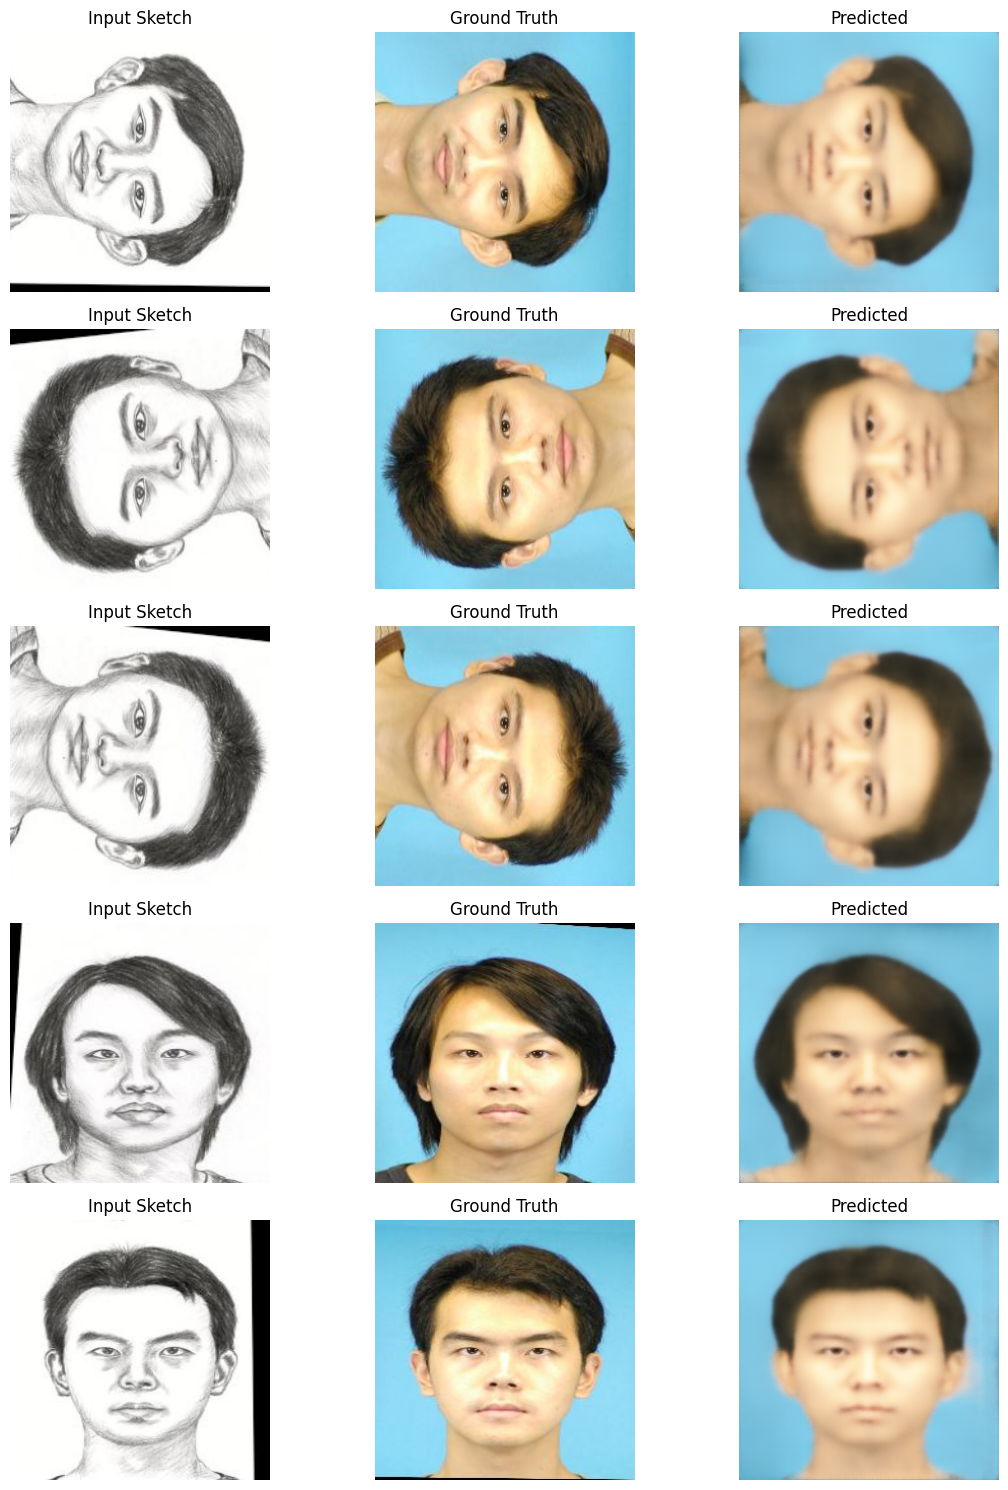

In [5]:
# Load best model
model.load_weights("best_model.keras")

# Predict on test data
predictions = model.predict(test_sketch_image)

# Visualize a few random predictions
import random

num_samples = 5  # how many samples to show
indices = random.sample(range(len(test_sketch_image)), num_samples)

plt.figure(figsize=(15, num_samples * 3))

for i, idx in enumerate(indices):
    sketch = test_sketch_image[idx]
    real = test_image[idx]
    pred = predictions[idx]
    
    # Sketch
    plt.subplot(num_samples, 4, i*4 + 1)
    plt.imshow(sketch)
    plt.title('Input Sketch')
    plt.axis('off')
    
    # Ground Truth
    plt.subplot(num_samples, 4, i*4 + 2)
    plt.imshow(real)
    plt.title('Ground Truth')
    plt.axis('off')
    
    # Prediction
    plt.subplot(num_samples, 4, i*4 + 3)
    plt.imshow(pred)
    plt.title('Predicted')
    plt.axis('off')

plt.tight_layout()
plt.show()

In [6]:
# Import metrics
from tensorflow.image import psnr, ssim

# Calculate PSNR and SSIM
psnr_values = psnr(test_image, predictions, max_val=1.0)
ssim_values = ssim(test_image, predictions, max_val=1.0)

# Mean PSNR and SSIM
mean_psnr = tf.reduce_mean(psnr_values).numpy()
mean_ssim = tf.reduce_mean(ssim_values).numpy()

print(f"Mean PSNR on Test Set: {mean_psnr:.2f} dB")
print(f"Mean SSIM on Test Set: {mean_ssim:.4f}")

Mean PSNR on Test Set: 19.41 dB
Mean SSIM on Test Set: 0.7634


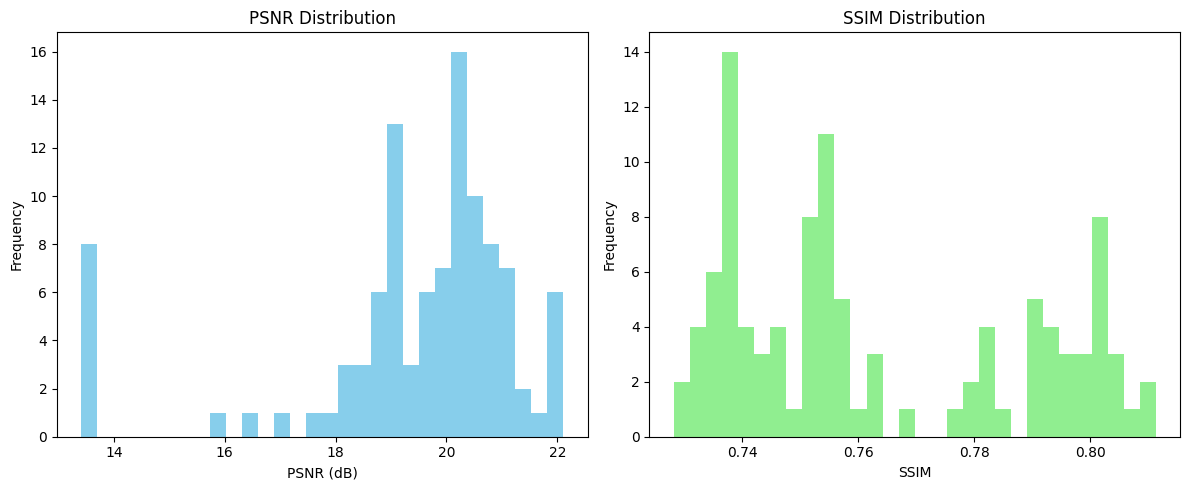

In [7]:
plt.figure(figsize=(12,5))

plt.subplot(1,2,1)
plt.hist(psnr_values.numpy(), bins=30, color='skyblue')
plt.title('PSNR Distribution')
plt.xlabel('PSNR (dB)')
plt.ylabel('Frequency')

plt.subplot(1,2,2)
plt.hist(ssim_values.numpy(), bins=30, color='lightgreen')
plt.title('SSIM Distribution')
plt.xlabel('SSIM')
plt.ylabel('Frequency')

plt.tight_layout()
plt.show()

In [ ]:
!tar -zcvf best_model.tar.gz /kaggle/working/best_model.keras

In [ ]:
!ls /kaggle/working

In [8]:
from IPython.display import FileLink
FileLink('/kaggle/working/best_model.keras')

d:\kaggle\working\best_model.keras